# Regression with Biwi Head Pose Dataset

This notebook illustrates a slightly more advanced example of how to create custom datasets and perform regression with images.

The goal is to find the center of the head in each image. The dataset is the [BWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db). Credit to Gabriele Fanelli et al.

Each training image is labeled with a red dot that indicates the center of the head of the individual appearing in the image. Our model will learn how to detect the center of a person's head, and attempt to predict this point for each image in the validation set.

The dataset can be downloaded from: https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz.

The images in the original dataset have been converted to jpeg format.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai import *
from fastai.vision import *

## Getting and converting the data

In [31]:
path = Config.data_path()/'biwi_head_pose'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/biwi_head_pose')

In [30]:
# Download and untar
url = 'https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose'
untar_data(url, fname=path/'biwi_head_pose.tgz', dest=path)

PosixPath('/home/jupyter/.fastai/data/biwi_head_pose')

In [32]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [33]:
fname = path/'09'/'frame_00667_rgb.jpg'

In [35]:
def img2txt_name(f): return f'{str(f)[:-7]}pose.txt'

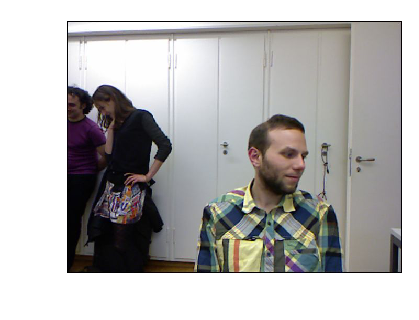

In [36]:
img = open_image(fname)
img.show()

In [37]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [38]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

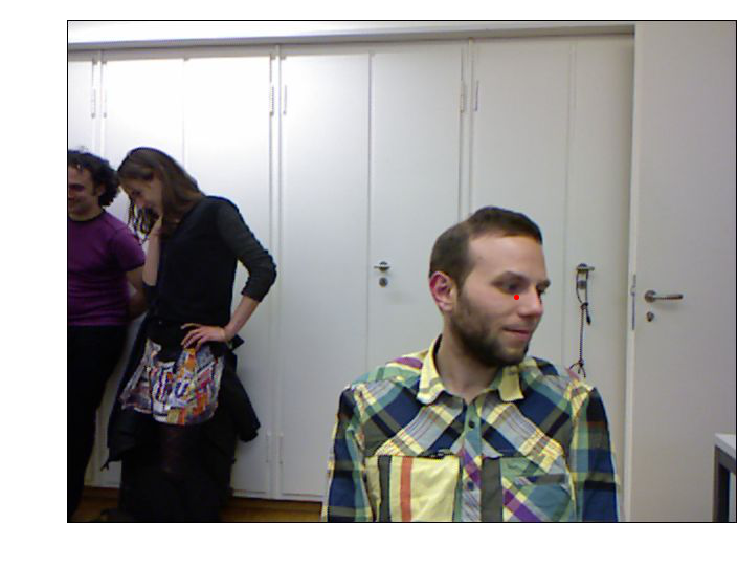

In [47]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating the Dataset

In [48]:
data = (ImageFileList.from_folder(path)
        .label_from_func(get_ctr)
        .split_by_valid_func(lambda o: o[0].parent.name=='13')
        .datasets(PointsDataset)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats))

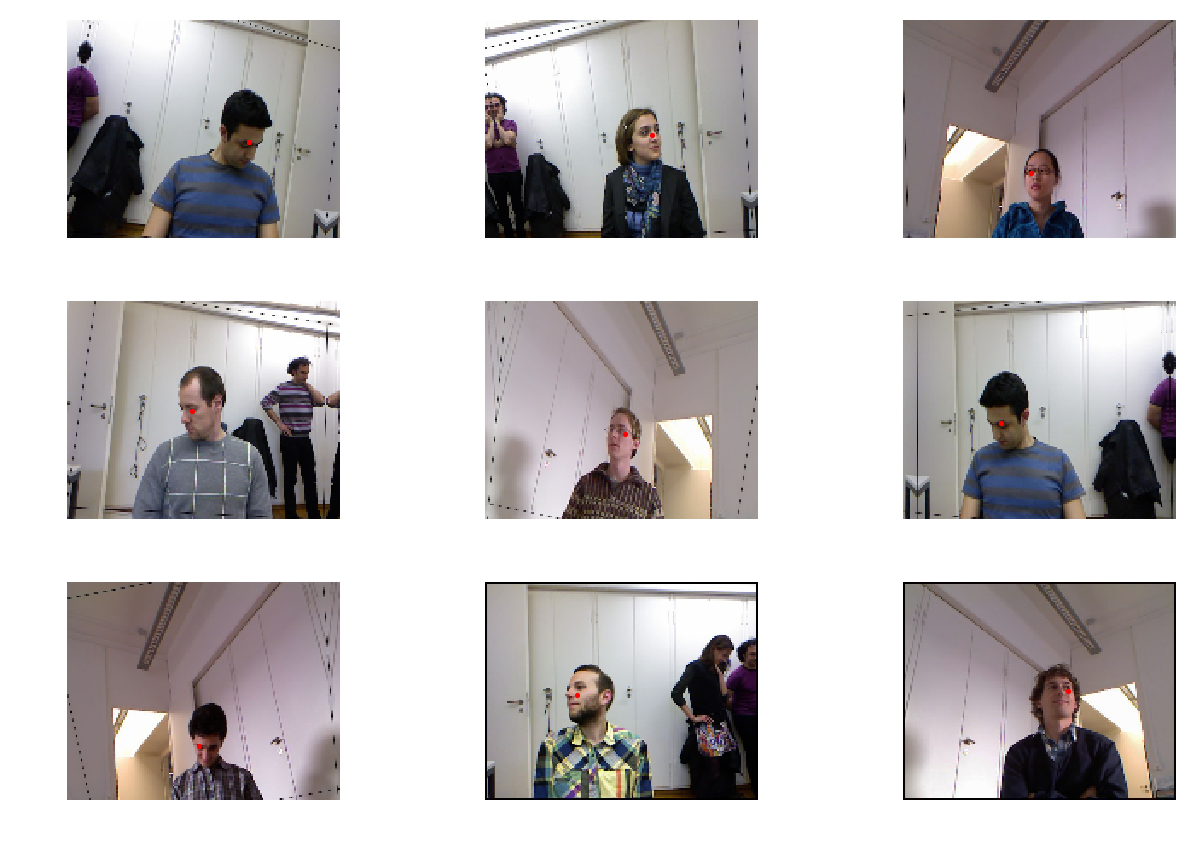

In [49]:
data.show_batch(3, figsize=(9,6))

## Training the Model

In [50]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


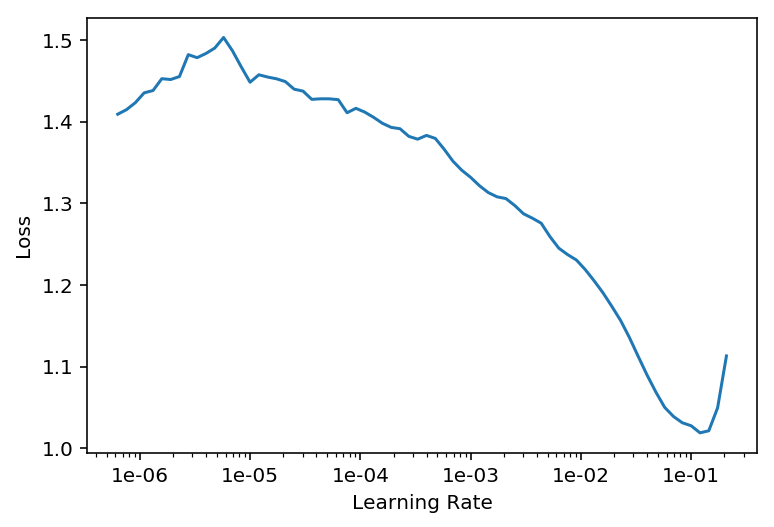

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
lr = 2e-2

In [53]:
learn.fit_one_cycle(5, slice(lr))

Total time: 03:55
epoch  train_loss  valid_loss
1      0.038244    0.009392    (00:47)
2      0.013833    0.009762    (00:46)
3      0.004989    0.001080    (00:47)
4      0.002901    0.000543    (00:47)
5      0.002055    0.000786    (00:46)



In [54]:
learn.save('stage-1')

In [55]:
learn.load('stage-1');

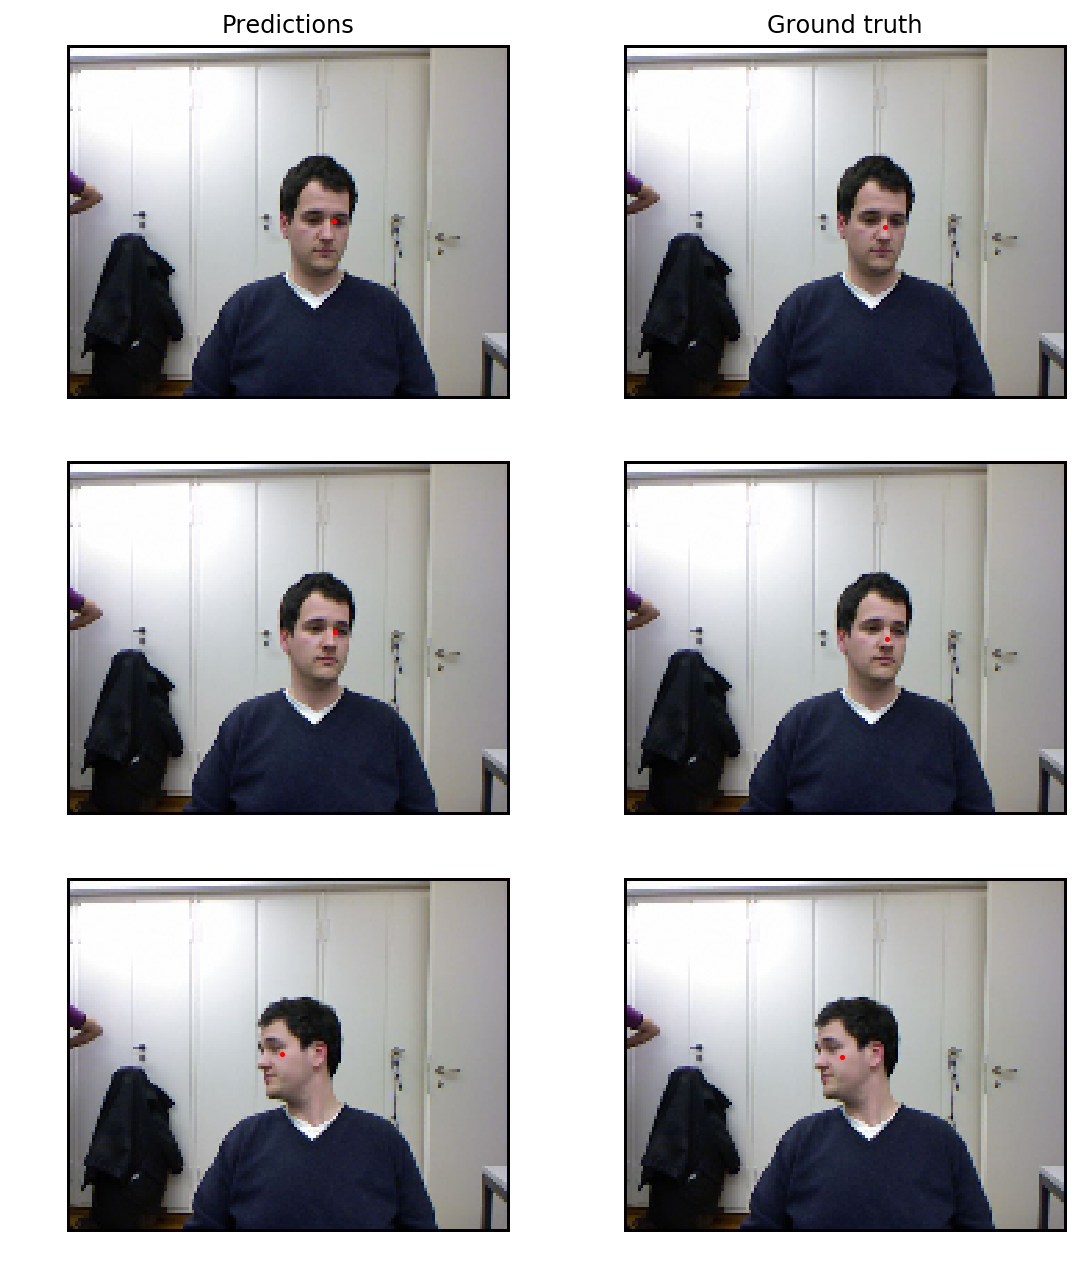

In [56]:
learn.show_results()